In [1]:
LOAD = False         # True = load previously saved model from disk?  False = (re)train the model
SAVE = "\_TFT_model_02.pth.tar"   # file name to save the model under

EPOCHS = 2
INLEN = 32          # input size
HIDDEN = 64         # hidden layers    
LSTMLAYERS = 2      # recurrent layers
ATTH = 4            # attention heads
BATCH = 32          # batch size
LEARN = 1e-3        # learning rate
DROPOUT = 0.1       # dropout rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
N_FC = 1            # output size

RAND = 42           # random seed
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = 3          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

SPLIT = 0.9         # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

mpath = os.path.abspath(os.getcwd()) + SAVE     # path and file name to save the model

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import missingno as mno

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape, rmse
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression


pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

# Wrangling and Exploration

In [3]:
# load
df0 = pd.read_csv("energy_dataset.csv", header=0, parse_dates=["time"])
dfw0 = pd.read_csv("weather_features.csv", header=0, parse_dates=["dt_iso"])

In [4]:
df0.iloc[[0, -1]]

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.00,329.00,0.00,"4,844.00","4,821.00",162.00,0.00,0.00,0.00,...,196.00,0.00,"6,378.00",17,NaN,6436,26118,"25,385.00",50.10,65.41
35063,2018-12-31 23:00:00+01:00,290.00,0.00,0.00,"6,926.00","2,166.00",163.00,0.00,0.00,0.00,...,287.00,0.00,"3,651.00",26,NaN,3117,24424,"24,455.00",64.27,69.88


In [5]:
dfw0.iloc[[0, -1]]

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.48,270.48,270.48,1001,77,1,62,0.00,0.00,0.00,0,800,clear,sky is clear,01n
178395,2018-12-31 23:00:00+01:00,Seville,283.97,282.15,285.15,1029,70,3,50,0.00,0.00,0.00,0,800,clear,sky is clear,01n


In [6]:
# backup of original sources
df1 = df0.copy()
dfw1 = dfw0.copy()

## Preparing the energy dataframe dfw1

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

count of duplicates: 0
non-numeric columns: []
MISSING values:



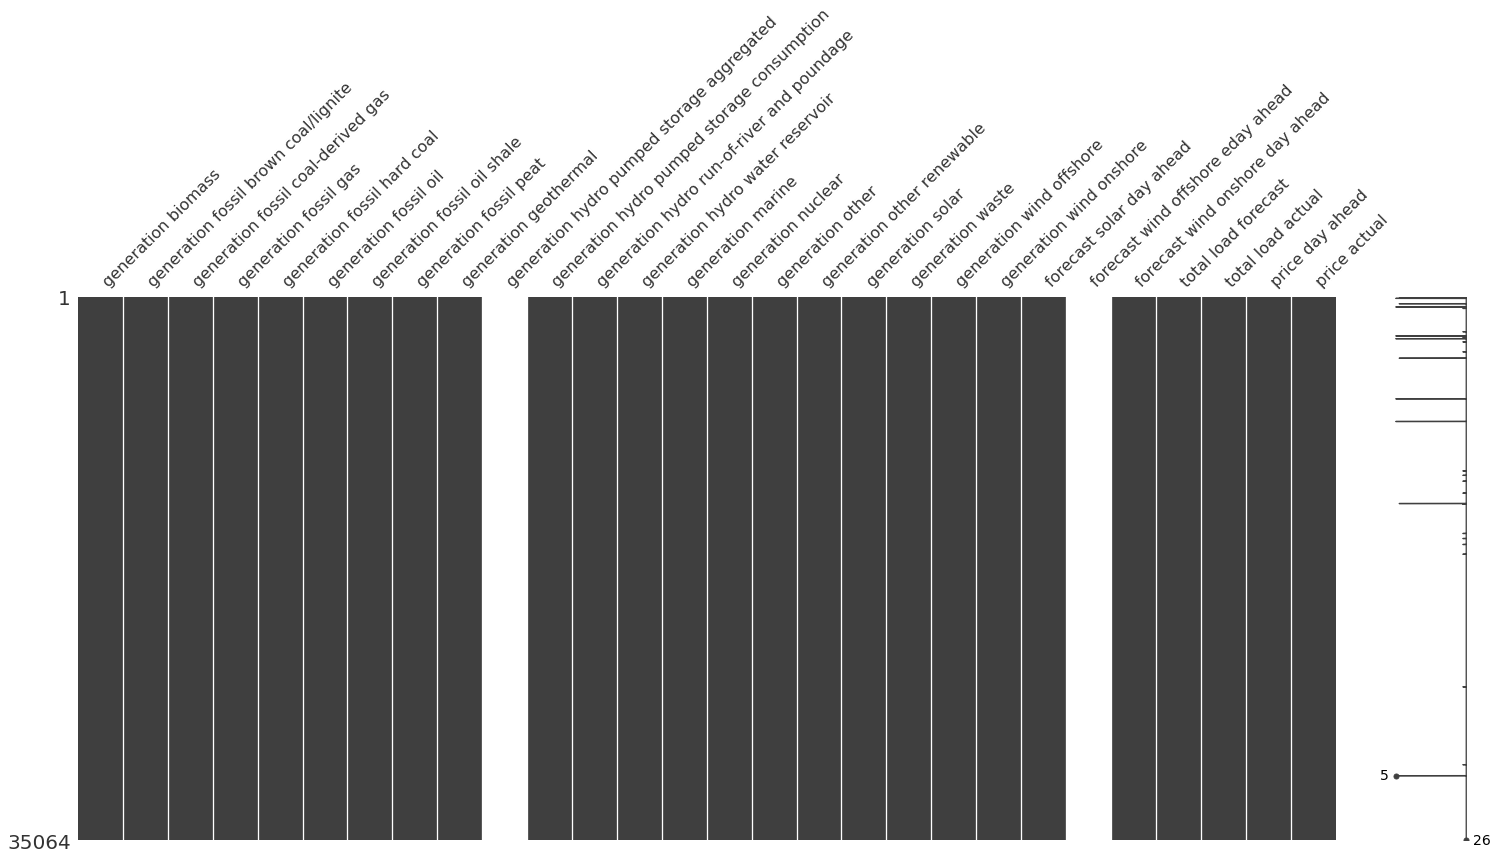

In [8]:
# datetime
df1["time"] = pd.to_datetime(df1["time"], utc=True, infer_datetime_format=True)


# any duplicate time periods?
print("count of duplicates:",df1.duplicated(subset=["time"], keep="first").sum())


df1.set_index("time", inplace=True)


# any non-numeric types?
print("non-numeric columns:",list(df1.dtypes[df1.dtypes == "object"].index))


# any missing values?
def gaps(df):
    if df.isnull().values.any():
        print("MISSING values:\n")
        mno.matrix(df)
    else:
        print("no missing values\n")
gaps(df1)  


In [9]:
# drop the NaN and zero columns, and also the 'forecast' columns
df1 = df1.drop(df1.filter(regex="forecast").columns, axis=1, errors="ignore")
df1.dropna(axis=1, how="all", inplace=True)
df1 = df1.loc[:, (df1!=0).any(axis=0)]

In [10]:
# handle missing values in rows of remaining columns
df1 = df1.interpolate(method ="bfill")
# any missing values left?
gaps(df1)

df1 = df1.loc[:, (df1!=0).any(axis=0)]

no missing values



In [11]:
# rename columns
colnames_old = df1.columns
colnames_new = ["gen_bio", "gen_lig", "gen_gas", "gen_coal", \
                "gen_oil", "gen_hyd_pump", "gen_hyd_river", "gen_hyd_res", \
                "gen_nuc", "gen_other", "gen_oth_renew", "gen_solar", \
                "gen_waste", "gen_wind", "load_actual", "price_dayahead", \
                "price"]
dict_cols = dict(zip(colnames_old, colnames_new))
df1.rename(columns=dict_cols, inplace=True)
print(df1.info())
df1.describe()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gen_bio         35064 non-null  float64
 1   gen_lig         35064 non-null  float64
 2   gen_gas         35064 non-null  float64
 3   gen_coal        35064 non-null  float64
 4   gen_oil         35064 non-null  float64
 5   gen_hyd_pump    35064 non-null  float64
 6   gen_hyd_river   35064 non-null  float64
 7   gen_hyd_res     35064 non-null  float64
 8   gen_nuc         35064 non-null  float64
 9   gen_other       35064 non-null  float64
 10  gen_oth_renew   35064 non-null  float64
 11  gen_solar       35064 non-null  float64
 12  gen_waste       35064 non-null  float64
 13  gen_wind        35064 non-null  float64
 14  load_actual     35064 non-null  float64
 15  price_dayahead  35064 non-null  float64
 16  price           35064 non-nul

,gen_bio,gen_lig,gen_gas,gen_coal,gen_oil,gen_hyd_pump,gen_hyd_river,gen_hyd_res,gen_nuc,gen_other,gen_oth_renew,gen_solar,gen_waste,gen_wind,load_actual,price_dayahead,price
count,"35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00"
mean,383.53,448.10,"5,622.70","4,256.51",298.34,475.60,972.20,"2,605.57","6,263.47",60.23,85.63,"1,432.83",269.42,"5,464.85","28,698.95",49.87,57.88
std,85.35,354.62,"2,201.48","1,962.01",52.52,792.34,400.71,"1,835.35",840.30,20.24,14.08,"1,679.95",50.22,"3,213.47","4,576.56",14.62,14.20
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"18,041.00",2.06,9.33
25%,333.00,0.00,"4,126.00","2,527.00",263.00,0.00,637.00,"1,078.00","5,759.00",53.00,73.00,71.00,240.00,"2,933.00","24,807.75",41.49,49.35
50%,367.00,509.00,"4,969.00","4,475.00",300.00,68.00,906.00,"2,164.00","6,564.00",57.00,88.00,616.00,279.00,"4,849.50","28,904.00",50.52,58.02
75%,433.00,757.00,"6,429.00","5,839.00",330.00,616.00,"1,250.00","3,758.00","7,025.00",80.00,97.00,"2,579.00",310.00,"7,401.00","32,195.00",60.53,68.01
max,592.00,999.00,"20,034.00","8,359.00",449.00,"4,523.00","2,000.00","9,728.00","7,117.00",106.00,119.00,"5,792.00",357.00,"17,436.00","41,015.00",101.99,116.80


In [12]:
# convert int and float64 columns to float32
intcols = list(df1.dtypes[df1.dtypes == np.int64].index)
df1[intcols] = df1[intcols].applymap(np.float32)

f64cols = list(df1.dtypes[df1.dtypes == np.float64].index)
df1[f64cols] = df1[f64cols].applymap(np.float32)

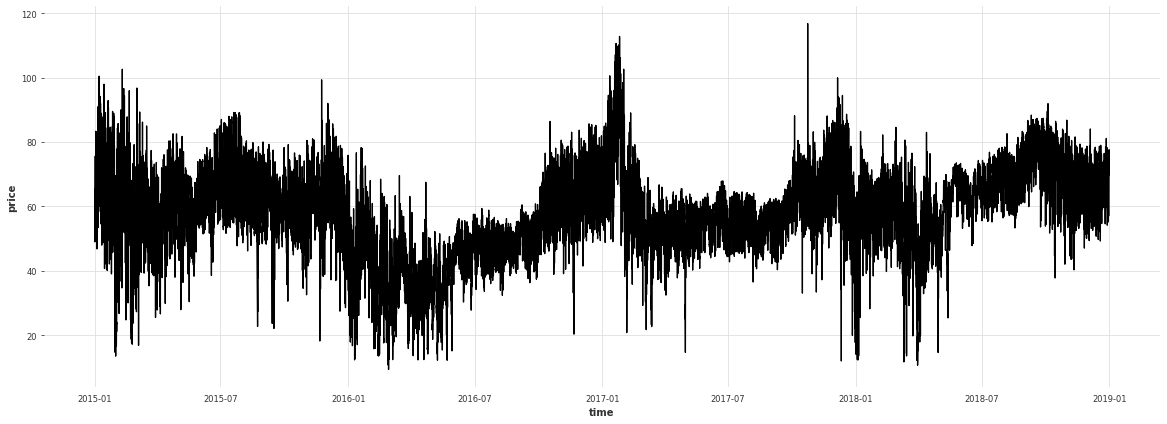

In [13]:
plt.figure(100, figsize=(20, 7))
sns.lineplot(x = "time", y = "price", data = df1, palette="coolwarm");

## Preparing the weather dataframe dfw1

In [14]:
dfw1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [15]:
# datetime
dfw1["time"] = pd.to_datetime(dfw1["dt_iso"], utc=True, infer_datetime_format=True)
dfw1.set_index("time", inplace=True)


# any non-numeric types?
print("non-numeric columns:",list(dfw1.dtypes[dfw1.dtypes == "object"].index))


# any missing values?
def gaps(df):
    if df.isnull().values.any():
        print("MISSING values:\n")
        mno.matrix(df)
    else:
        print("no missing values\n")  
gaps(dfw1) 


dfw1.describe()

non-numeric columns: ['dt_iso', 'city_name', 'weather_main', 'weather_description', 'weather_icon']
no missing values



,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,"178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00"
mean,289.62,288.33,291.09,"1,069.26",68.42,2.47,166.59,0.08,0.00,0.00,25.07,759.83
std,8.03,7.96,8.61,"5,969.63",21.90,2.10,116.61,0.40,0.01,0.22,30.77,108.73
min,262.24,262.24,262.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,200.00
25%,283.67,282.48,284.65,"1,013.00",53.00,1.00,55.00,0.00,0.00,0.00,0.00,800.00
50%,289.15,288.15,290.15,"1,018.00",72.00,2.00,177.00,0.00,0.00,0.00,20.00,800.00
75%,295.15,293.73,297.15,"1,022.00",87.00,4.00,270.00,0.00,0.00,0.00,40.00,801.00
max,315.60,315.15,321.15,"1,008,371.00",100.00,133.00,360.00,12.00,2.31,21.50,100.00,804.00


In [16]:
# drop unnecessary columns
dfw1.drop(["rain_3h", "weather_id", "weather_main", "weather_description", "weather_icon"], 
          inplace=True, axis=1, errors="ignore")


# temperature: kelvin to celsius
temp_cols = [col for col in dfw1.columns if "temp" in col]
dfw1[temp_cols] = dfw1[temp_cols].filter(like="temp").applymap(lambda t: t - 273.15)


In [17]:
# convert int and float64 columns to float32
intcols = list(dfw1.dtypes[dfw1.dtypes == np.int64].index)
dfw1[intcols] = dfw1[intcols].applymap(np.float32)

f64cols = list(dfw1.dtypes[dfw1.dtypes == np.float64].index)
dfw1[f64cols] = dfw1[f64cols].applymap(np.float32)

f32cols = list(dfw1.dtypes[dfw1.dtypes == np.float32].index)
dfw1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178396 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   dt_iso      178396 non-null  object 
 1   city_name   178396 non-null  object 
 2   temp        178396 non-null  float32
 3   temp_min    178396 non-null  float32
 4   temp_max    178396 non-null  float32
 5   pressure    178396 non-null  float32
 6   humidity    178396 non-null  float32
 7   wind_speed  178396 non-null  float32
 8   wind_deg    178396 non-null  float32
 9   rain_1h     178396 non-null  float32
 10  snow_3h     178396 non-null  float32
 11  clouds_all  178396 non-null  float32
dtypes: float32(10), object(2)
memory usage: 10.9+ MB


In [18]:
#investigate the outliers in the pressure column
dfw1["pressure"].nlargest(10)

time
2015-02-21 01:00:00+00:00   1,008,371.00
2015-02-22 07:00:00+00:00   1,002,881.00
2015-02-22 06:00:00+00:00   1,002,241.00
2015-02-21 08:00:00+00:00   1,001,781.00
2015-02-21 09:00:00+00:00   1,001,501.00
2015-02-21 10:00:00+00:00   1,000,951.00
2015-02-20 08:00:00+00:00     102,153.00
2015-02-20 09:00:00+00:00     102,132.00
2015-02-20 10:00:00+00:00     102,075.00
2015-02-20 11:00:00+00:00     101,983.00
Name: pressure, dtype: float32

In [19]:
#investigate the outliers in the wind_speed column
dfw1["wind_speed"].nlargest(10)

time
2017-05-11 10:00:00+00:00   133.00
2015-01-30 10:00:00+00:00    64.00
2015-01-30 14:00:00+00:00    54.00
2015-02-23 21:00:00+00:00    43.00
2015-01-30 15:00:00+00:00    40.00
2015-01-30 18:00:00+00:00    38.00
2015-01-30 02:00:00+00:00    35.00
2015-01-30 09:00:00+00:00    33.00
2015-01-16 12:00:00+00:00    30.00
2015-01-29 13:00:00+00:00    30.00
Name: wind_speed, dtype: float32

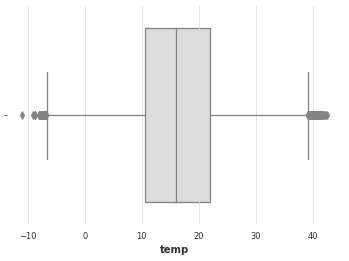

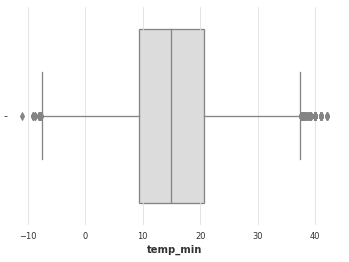

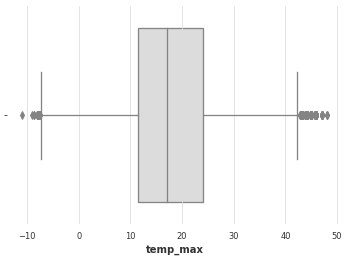

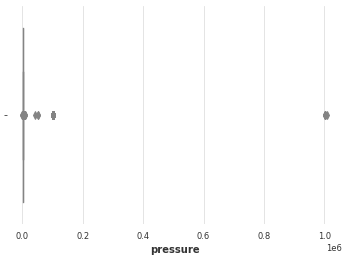

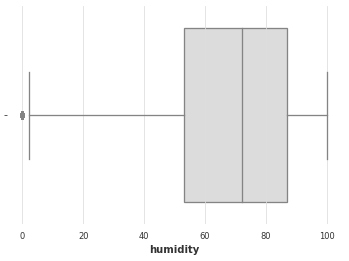

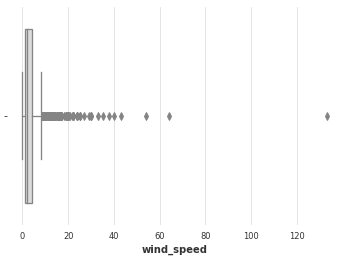

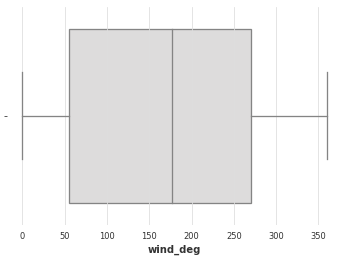

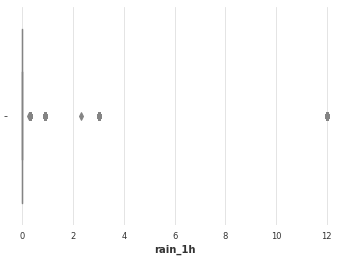

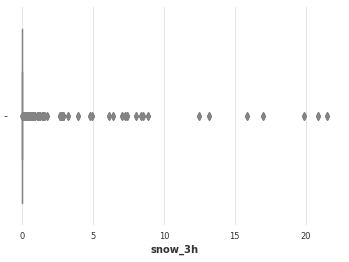

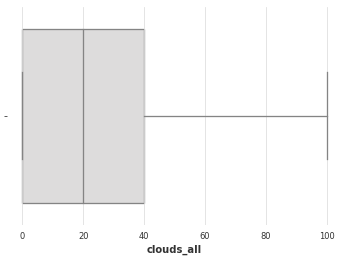

In [20]:
# boxplots
for i, c in enumerate(f32cols):
    sns.boxplot(x=dfw1[c], palette="coolwarm")
    plt.show();

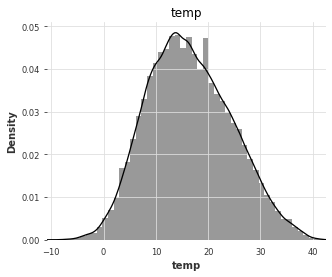

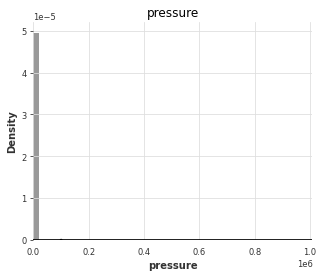

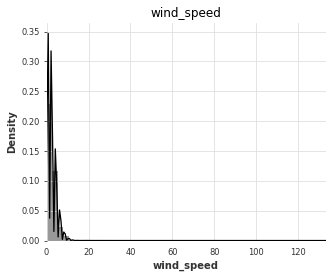

In [21]:
# or use distplot to visualize outliers
fig = plt.figure(figsize=(5, 4)) 
ax = sns.distplot(dfw1["temp"])
xmin = dfw1["temp"].min()
xmax = dfw1["temp"].max()  
ax.set_xlim(xmin, xmax)
ax.set_title("temp");

fig = plt.figure(figsize=(5, 4))
ax = sns.distplot(dfw1["pressure"])
xmin = dfw1["pressure"].min()
xmax = dfw1["pressure"].max()  
ax.set_xlim(xmin, xmax)
ax.set_title("pressure");

fig = plt.figure(figsize=(5, 4))
ax = sns.distplot(dfw1["wind_speed"])
xmin = dfw1["wind_speed"].min()
xmax = dfw1["wind_speed"].max()  
ax.set_xlim(xmin, xmax)
ax.set_title("wind_speed");

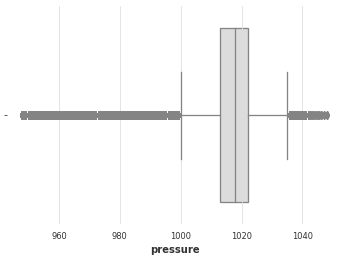

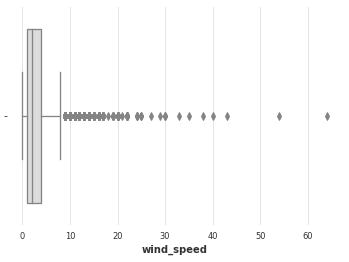

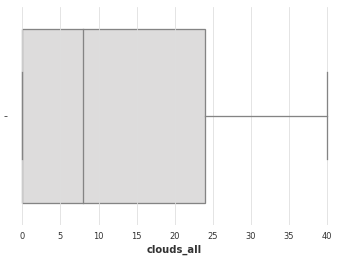

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
count,"178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00"
mean,16.47,15.18,17.94,"1,016.16",68.42,2.47,166.59,0.08,0.00,14.59
std,8.03,7.96,8.61,11.68,21.90,2.07,116.61,0.40,0.22,16.04
min,-10.91,-10.91,-10.91,948.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,10.52,9.33,11.50,"1,013.00",53.00,1.00,55.00,0.00,0.00,0.00
50%,16.00,15.00,17.00,"1,018.00",72.00,2.00,177.00,0.00,0.00,8.00
75%,22.00,20.58,24.00,"1,022.00",87.00,4.00,270.00,0.00,0.00,24.00
max,42.45,42.00,48.00,"1,048.00",100.00,64.00,360.00,12.00,21.50,40.00


In [22]:
# treatment of outliers: replace with NaN, then interpolate
dfw1["pressure"].where( dfw1["pressure"] <= 1050, inplace=True)
dfw1["pressure"].where( dfw1["pressure"] >= 948, inplace=True)
dfw1["wind_speed"].where( dfw1["wind_speed"] <= 120, inplace=True)
dfw1["clouds_all"].where( dfw1["clouds_all"] <= 40, inplace=True)
dfw1 = dfw1.interpolate(method ="bfill")

sns.boxplot(x=dfw1["pressure"], palette="coolwarm")
plt.show();
sns.boxplot(x=dfw1["wind_speed"], palette="coolwarm")
plt.show();
sns.boxplot(x=dfw1["clouds_all"], palette="coolwarm")
plt.show();

dfw1.describe()

In [23]:
# start and end of energy and weather time series 
print("earliest weather time period:", dfw1.index.min())
print("latest weather time period:", dfw1.index.max())

print("earliest energy time period:", df1.index.min())
print("latest energy time period:", df1.index.max())

earliest weather time period: 2014-12-31 23:00:00+00:00
latest weather time period: 2018-12-31 22:00:00+00:00
earliest energy time period: 2014-12-31 23:00:00+00:00
latest energy time period: 2018-12-31 22:00:00+00:00


In [24]:
# cities in weather data
cities = dfw1["city_name"].unique()
cities

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

In [25]:
# drop duplicate time periods
print("count of duplicates before treatment:",dfw1.duplicated(subset=["dt_iso", "city_name"], keep="first").sum())

dfw1 = dfw1.drop_duplicates(subset=["dt_iso", "city_name"], keep="first")
dfw1.reset_index()
print("count of duplicates after treatment:",dfw1.duplicated(subset=["dt_iso", "city_name"], keep="first").sum())

# set datetime index
dfw1["time"] = pd.to_datetime(dfw1["dt_iso"], utc=True, infer_datetime_format=True)
dfw1.set_index("time", inplace=True)
dfw1.drop("dt_iso", inplace=True, axis=1)


print("size of energy dataframe:", df1.shape[0])
dfw1_city = dfw1.groupby("city_name").count()
dfw1_city

count of duplicates before treatment: 3076
count of duplicates after treatment: 0
size of energy dataframe: 35064


,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
city_name,,,,,,,,,,
Barcelona,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064
Bilbao,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064
Madrid,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064
Seville,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064
Valencia,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064


In [26]:
# count of weather observations by city
print("size of energy dataframe:", df1.shape[0])

dfw1["city_name"] = dfw1["city_name"].replace(" Barcelona", "Barcelona")   # remove space in name
dfw1_city = dfw1.groupby("city_name")
print("size of city groups in weather dataframe:")
dfw1_city.count()

size of energy dataframe: 35064
size of city groups in weather dataframe:


,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
city_name,,,,,,,,,,
Barcelona,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064
Bilbao,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064
Madrid,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064
Seville,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064
Valencia,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064


In [27]:
# separate the cities: a weather dataframe for each of them
dict_city_weather = {city:df_city for city,df_city in dfw1_city}
dict_city_weather.keys()

dict_keys(['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia'])

In [28]:
# example: Bilbao weather dataframe
dfw_Bilbao = dict_city_weather.get("Bilbao")
print("Bilbao weather:")
dfw_Bilbao.describe()

Bilbao weather:


,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
count,"35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00"
mean,13.29,11.84,14.94,"1,017.48",78.73,1.96,159.91,0.12,0.02,22.97
std,6.80,6.82,6.99,9.82,16.71,1.87,122.86,0.37,0.50,16.66
min,-6.30,-9.00,-4.17,961.00,11.00,0.00,0.00,0.00,0.00,0.00
25%,8.30,7.00,10.00,"1,013.00",67.00,1.00,31.00,0.00,0.00,0.00
50%,13.02,11.70,15.00,"1,019.00",82.00,1.00,150.00,0.00,0.00,20.00
75%,17.89,17.00,19.36,"1,024.00",93.00,3.00,290.00,0.00,0.00,40.00
max,39.32,38.89,45.56,"1,042.00",100.00,15.00,360.00,3.00,21.50,40.00


In [29]:
dfw_Bilbao.iloc[[0,-1]]

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
time,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Bilbao,-3.49,-3.49,-3.49,"1,036.00",97.00,0.00,226.00,0.00,0.00,0.00
2018-12-31 22:00:00+00:00,Bilbao,2.45,2.00,3.00,"1,034.00",93.00,2.00,100.00,0.00,0.00,0.00


In [30]:
# merge the energy and weather dataframes
df2 = df1.copy()
for city,df in dict_city_weather.items():
    city_name = str(city) + "_"
    df = df.add_suffix("_{}".format(city))
    df2 = pd.concat([df2, df], axis=1)
    df2.drop("city_name_" + city, inplace=True, axis=1)
print(df2.info())
df2.iloc[[0,-1]]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 67 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gen_bio               35064 non-null  float32
 1   gen_lig               35064 non-null  float32
 2   gen_gas               35064 non-null  float32
 3   gen_coal              35064 non-null  float32
 4   gen_oil               35064 non-null  float32
 5   gen_hyd_pump          35064 non-null  float32
 6   gen_hyd_river         35064 non-null  float32
 7   gen_hyd_res           35064 non-null  float32
 8   gen_nuc               35064 non-null  float32
 9   gen_other             35064 non-null  float32
 10  gen_oth_renew         35064 non-null  float32
 11  gen_solar             35064 non-null  float32
 12  gen_waste             35064 non-null  float32
 13  gen_wind              35064 non-null  float32
 14  load_actual           3

,gen_bio,gen_lig,gen_gas,gen_coal,gen_oil,gen_hyd_pump,gen_hyd_river,gen_hyd_res,gen_nuc,gen_other,...,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.00,329.00,"4,844.00","4,821.00",162.00,863.00,"1,051.00","1,899.00","7,096.00",43.00,...,-2.67,-2.67,-2.67,"1,001.00",77.00,1.00,62.00,0.00,0.00,0.00
2018-12-31 22:00:00+00:00,290.00,0.00,"6,926.00","2,166.00",163.00,108.00,"1,069.00","1,686.00","6,075.00",61.00,...,5.99,5.00,7.00,"1,029.00",75.00,2.00,300.00,0.00,0.00,0.00


In [31]:
# any null values?
print("any missing values?", df2.isnull().values.any())

# any ducplicate time periods?
print("count of duplicates:", df2.duplicated(keep="first").sum())

any missing values? False
count of duplicates: 0


# Exploration of Combined Dataframe

In [32]:
# limit the dataframe's date range
df2 = df2[df2.index >= "2018-01-01 00:00:00+00:00"]
df2.iloc[[0,-1]]

,gen_bio,gen_lig,gen_gas,gen_coal,gen_oil,gen_hyd_pump,gen_hyd_river,gen_hyd_res,gen_nuc,gen_other,...,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,275.00,0.00,"3,269.00",959.00,191.00,"2,115.00","1,046.00",799.00,"7,057.00",51.00,...,14.00,14.00,14.00,"1,026.00",44.00,5.00,270.00,0.00,0.00,0.00
2018-12-31 22:00:00+00:00,290.00,0.00,"6,926.00","2,166.00",163.00,108.00,"1,069.00","1,686.00","6,075.00",61.00,...,5.99,5.00,7.00,"1,029.00",75.00,2.00,300.00,0.00,0.00,0.00


In [33]:
# check correlations of features with price
df_corr = df2.corr(method="pearson")
print(df_corr.shape)
print("correlation with price:")
df_corrP = pd.DataFrame(df_corr["price"].sort_values(ascending=False))
df_corrP

(67, 67)
correlation with price:


,price
price,1.00
price_dayahead,0.67
gen_gas,0.49
gen_coal,0.46
temp_max_Seville,0.42
...,...
snow_3h_Barcelona,NaN
snow_3h_Bilbao,NaN
snow_3h_Madrid,NaN
snow_3h_Seville,NaN


In [34]:
# highest absolute correlations with price
pd.options.display.float_format = '{:,.2f}'.format
df_corrH = df_corrP[np.abs(df_corrP["price"]) > 0.25]
df_corrH

,price
price,1.00
price_dayahead,0.67
gen_gas,0.49
gen_coal,0.46
temp_max_Seville,0.42
load_actual,0.41
temp_Seville,0.41
temp_min_Seville,0.41
temp_max_Madrid,0.40
temp_Madrid,0.39


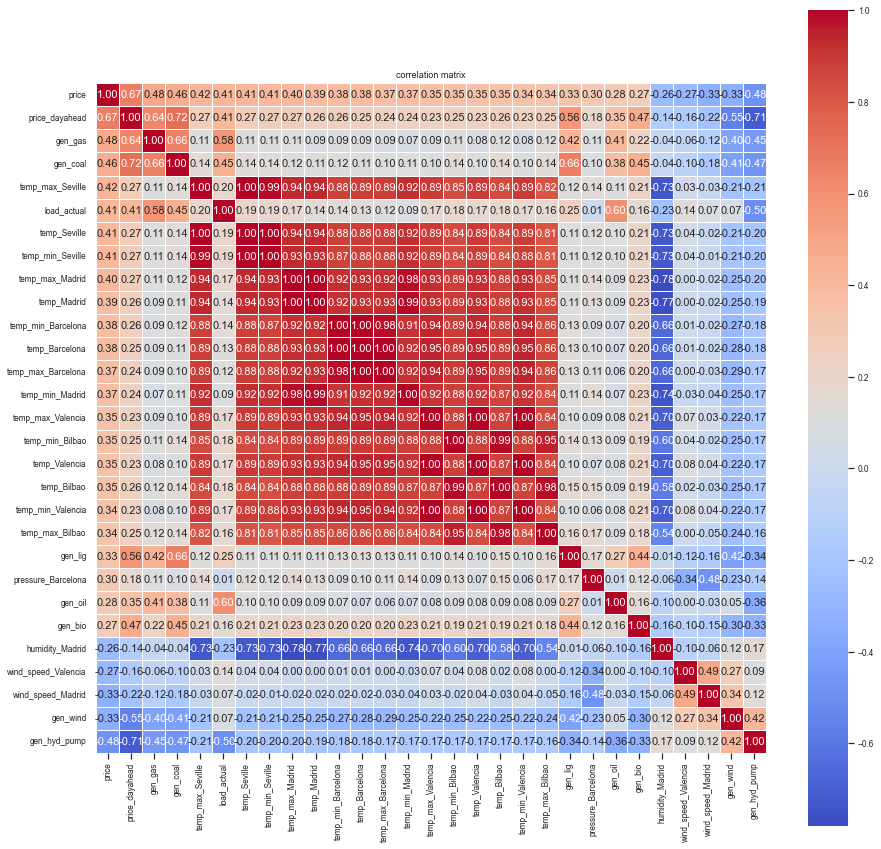

In [35]:
# correlation matrix, limited to highly correlated features
df3 = df2[df_corrH.index]

idx = df3.corr().sort_values("price", ascending=False).index
df3_sorted = df3.loc[:, idx]  # sort dataframe columns by their correlation with Appliances

plt.figure(figsize = (15,15))
sns.set(font_scale=0.75)
ax = sns.heatmap(df3_sorted.corr().round(3), 
            annot=True, 
            square=True, 
            linewidths=.75, cmap="coolwarm", 
            fmt = ".2f", 
            annot_kws = {"size": 11})
ax.xaxis.tick_bottom()
plt.title("correlation matrix")
plt.show()

In [36]:
# limit energy dataframe to columns that have 
# at least a moderate correlation with price
df3 = df2[df_corrH.index]
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8759 entries, 2018-01-01 00:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                8759 non-null   float32
 1   price_dayahead       8759 non-null   float32
 2   gen_gas              8759 non-null   float32
 3   gen_coal             8759 non-null   float32
 4   temp_max_Seville     8759 non-null   float32
 5   load_actual          8759 non-null   float32
 6   temp_Seville         8759 non-null   float32
 7   temp_min_Seville     8759 non-null   float32
 8   temp_max_Madrid      8759 non-null   float32
 9   temp_Madrid          8759 non-null   float32
 10  temp_min_Barcelona   8759 non-null   float32
 11  temp_Barcelona       8759 non-null   float32
 12  temp_max_Barcelona   8759 non-null   float32
 13  temp_min_Madrid      8759 non-null   float32
 14  temp_max_Valencia    8759 non-null   flo

In [37]:
# additional datetime columns: feature engineering
df3["month"] = df3.index.month

df3["wday"] = df3.index.dayofweek
dict_days = {0:"1_Mon", 1:"2_Tue", 2:"3_Wed", 3:"4_Thu", 4:"5_Fri", 5:"6_Sat", 6:"7_Sun"}
df3["weekday"] = df3["wday"].apply(lambda x: dict_days[x])

df3["hour"] = df3.index.hour

df3 = df3.astype({"hour":float, "wday":float, "month": float})

df3.iloc[[0, -1]]

,price,price_dayahead,gen_gas,gen_coal,temp_max_Seville,load_actual,temp_Seville,temp_min_Seville,temp_max_Madrid,temp_Madrid,...,gen_bio,humidity_Madrid,wind_speed_Valencia,wind_speed_Madrid,gen_wind,gen_hyd_pump,month,wday,weekday,hour
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,19.02,4.74,"3,269.00",959.00,11.00,"22,009.00",10.39,10.00,7.00,6.43,...,275.00,65.00,5.00,4.00,"11,156.00","2,115.00",1.00,0.00,1_Mon,0.00
2018-12-31 22:00:00+00:00,69.88,64.27,"6,926.00","2,166.00",12.00,"24,455.00",10.82,9.00,2.00,2.00,...,290.00,74.00,2.00,1.00,"3,651.00",108.00,12.00,0.00,1_Mon,22.00


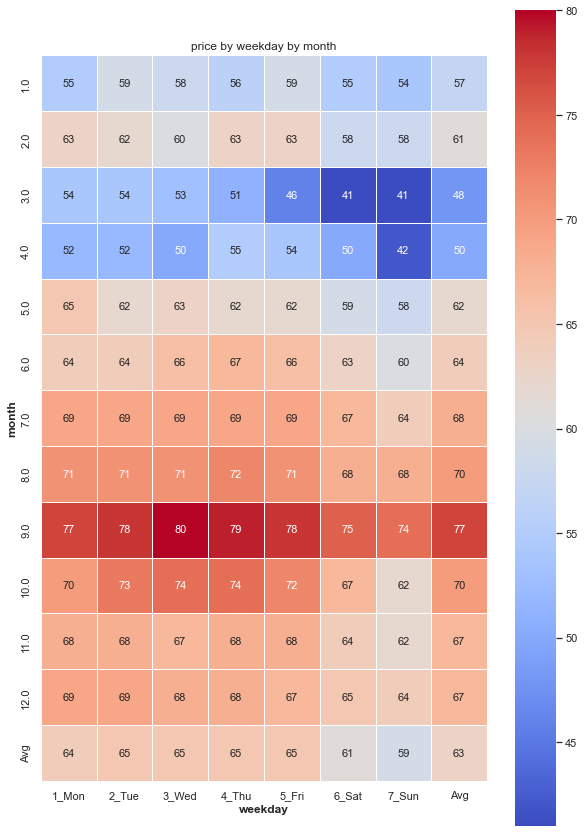

In [38]:
# pivot table: weekdays in months
piv = pd.pivot_table(   df3, 
                        values="price", 
                        index="month", 
                        columns="weekday", 
                        aggfunc="mean", 
                        margins=True, margins_name="Avg", 
                        fill_value=0)
pd.options.display.float_format = '{:,.0f}'.format

plt.figure(figsize = (10,15))
sns.set(font_scale=1)
sns.heatmap(piv.round(0), annot=True, square = True, \
            linewidths=.75, cmap="coolwarm", fmt = ".0f", annot_kws = {"size": 11})
plt.title("price by weekday by month")
plt.show()

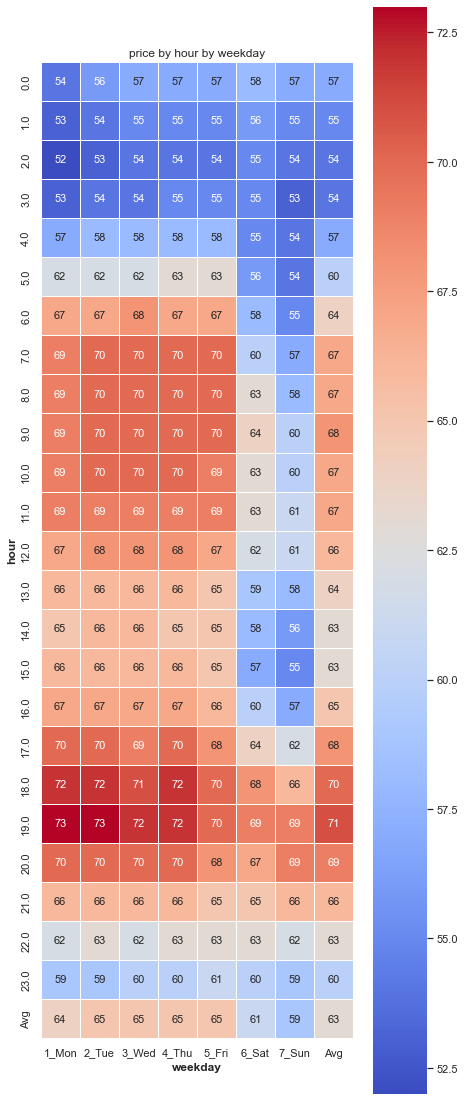

In [39]:
# pivot table: hours in weekdays
piv = pd.pivot_table(   df3, 
                        values="price", 
                        index="hour", 
                        columns="weekday", 
                        aggfunc="mean", 
                        margins=True, margins_name="Avg", 
                        fill_value=0)
pd.options.display.float_format = '{:,.0f}'.format

plt.figure(figsize = (7,20))
sns.set(font_scale=1)
sns.heatmap(piv.round(0), annot=True, square = True, \
            linewidths=.75, cmap="coolwarm", fmt = ".0f", annot_kws = {"size": 11})
plt.title("price by hour by weekday")
plt.show()

In [40]:
# dataframe with price and features only
df4 = df3.copy()
df4.drop(["weekday", "month", "wday", "hour"], inplace=True, axis=1)

# Time Series Object

In [41]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df4["price"]) 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['price'], dtype='object', name='component')
duration: 364 days 22:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [42]:
# create time series object for the feature columns
df_covF = df4.loc[:, df4.columns != "price"]
ts_covF = TimeSeries.from_dataframe(df_covF)

# check attributes of the time series
print("components (columns) of feature time series:", ts_covF.components)
print("duration:",ts_covF.duration)
print("frequency:",ts_covF.freq)
print("frequency:",ts_covF.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_covF.has_datetime_index)
print("deterministic:",ts_covF.is_deterministic)
print("univariate:",ts_covF.is_univariate)


components (columns) of feature time series: Index(['price_dayahead', 'gen_gas', 'gen_coal', 'temp_max_Seville',
       'load_actual', 'temp_Seville', 'temp_min_Seville', 'temp_max_Madrid',
       'temp_Madrid', 'temp_min_Barcelona', 'temp_Barcelona',
       'temp_max_Barcelona', 'temp_min_Madrid', 'temp_max_Valencia',
       'temp_min_Bilbao', 'temp_Valencia', 'temp_Bilbao', 'temp_min_Valencia',
       'temp_max_Bilbao', 'gen_lig', 'pressure_Barcelona', 'gen_oil',
       'gen_bio', 'humidity_Madrid', 'wind_speed_Valencia',
       'wind_speed_Madrid', 'gen_wind', 'gen_hyd_pump'],
      dtype='object', name='component')
duration: 364 days 22:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: False


In [43]:
# example: operating with time series objects:
# we can also create a 3-dimensional numpy array from a time series object
# 3 dimensions: time (rows) / components (columns) / samples
ar_covF = ts_covF.all_values()
print(type(ar_covF))
ar_covF.shape

<class 'numpy.ndarray'>


(8759, 28, 1)

In [44]:
# example: operating with time series objects:
# we can also create a pandas series or dataframe from a time series object
df_covF = ts_covF.pd_dataframe()
type(df_covF)

pandas.core.frame.DataFrame

In [45]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(SPLIT)
print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled price time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2018-01-01 00:00:00+00:00
training end: 2018-11-25 10:00:00+00:00
training duration: 328 days 10:00:00
test start: 2018-11-25 11:00:00+00:00
test end: 2018-12-31 22:00:00+00:00
test duration: 36 days 11:00:00
first and last row of scaled price time series:


component,price
time,
2018-01-01 00:00:00+00:00,0.10
2018-12-31 22:00:00+00:00,0.73


In [46]:
# train/test split and scaling of feature covariates
covF_train, covF_test = ts_covF.split_after(SPLIT)

scalerF = Scaler()
scalerF.fit_transform(covF_train)
covF_ttrain = scalerF.transform(covF_train) 
covF_ttest = scalerF.transform(covF_test)   
covF_t = scalerF.transform(ts_covF)  

# make sure data are of type float
covF_ttrain = covF_ttrain.astype(np.float32)
covF_ttest = covF_ttest.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled feature covariates:")
covF_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled feature covariates:


component,price_dayahead,gen_gas,gen_coal,temp_max_Seville,load_actual,temp_Seville,temp_min_Seville,temp_max_Madrid,temp_Madrid,temp_min_Barcelona,...,temp_max_Bilbao,gen_lig,pressure_Barcelona,gen_oil,gen_bio,humidity_Madrid,wind_speed_Valencia,wind_speed_Madrid,gen_wind,gen_hyd_pump
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,0.03,0.25,0.04,0.27,0.15,0.28,0.29,0.26,0.26,0.44,...,0.38,0.00,0.59,0.46,0.67,0.62,0.33,0.24,0.69,0.50
2018-12-31 22:00:00+00:00,0.76,0.52,0.24,0.30,0.26,0.29,0.27,0.15,0.16,0.17,...,0.17,0.00,0.82,0.37,0.70,0.72,0.13,0.06,0.22,0.03


In [47]:
# feature engineering - create time covariates: hour, weekday, month, year, country-specific holidays
covT = datetime_attribute_timeseries( ts_P.time_index, attribute="hour", add_length=48 )   # 48 hours beyond end of test set to prepare for out-of-sample forecasting
covT = covT.stack(  datetime_attribute_timeseries(covT.time_index, attribute="day_of_week")  )
covT = covT.stack(  datetime_attribute_timeseries(covT.time_index, attribute="month")  )
covT = covT.stack(  datetime_attribute_timeseries(covT.time_index, attribute="year")  )

covT = covT.add_holidays(country_code="ES")
covT = covT.astype(np.float32)


# train/test split
covT_train, covT_test = covT.split_after(ts_train.end_time())


# rescale the covariates: fitting on the training set
scalerT = Scaler()
scalerT.fit(covT_train)
covT_ttrain = scalerT.transform(covT_train)
covT_ttest = scalerT.transform(covT_test)
covT_t = scalerT.transform(covT)

covT_t = covT_t.astype(np.float32)


pd.options.display.float_format = '{:.0f}'.format
print("first and last row of unscaled time covariates:")
covT.pd_dataframe().iloc[[0,-1]]

first and last row of unscaled time covariates:


component,hour,day_of_week,month,year,holidays
time,,,,,
2018-01-01 00:00:00+00:00,0,0,1,2018,1
2019-01-02 22:00:00+00:00,22,2,1,2019,0


In [48]:
# combine feature and time covariates along component dimension: axis=1
ts_cov = ts_covF.concatenate( covT.slice_intersect(ts_covF), axis=1 )                      # unscaled F+T
cov_t = covF_t.concatenate( covT_t.slice_intersect(covF_t), axis=1 )                       # scaled F+T
cov_ttrain = covF_ttrain.concatenate( covT_ttrain.slice_intersect(covF_ttrain), axis=1 )   # scaled F+T training set
cov_ttest = covF_ttest.concatenate( covT_ttest.slice_intersect(covF_ttest), axis=1 )       # scaled F+T test set


pd.options.display.float_format = '{:.2f}'.format
print("first and last row of unscaled covariates:")
ts_cov.pd_dataframe().iloc[[0,-1]]

first and last row of unscaled covariates:


component,price_dayahead,gen_gas,gen_coal,temp_max_Seville,load_actual,temp_Seville,temp_min_Seville,temp_max_Madrid,temp_Madrid,temp_min_Barcelona,...,humidity_Madrid,wind_speed_Valencia,wind_speed_Madrid,gen_wind,gen_hyd_pump,hour,day_of_week,month,year,holidays
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,4.74,3269.00,959.00,11.00,22009.00,10.39,10.00,7.00,6.43,14.00,...,65.00,5.00,4.00,11156.00,2115.00,0.00,0.00,1.00,2018.00,1.00
2018-12-31 22:00:00+00:00,64.27,6926.00,2166.00,12.00,24455.00,10.82,9.00,2.00,2.00,4.00,...,74.00,2.00,1.00,3651.00,108.00,22.00,0.00,12.00,2018.00,0.00


In [49]:
pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled covariates, training + test set:")
cov_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled covariates, training + test set:


component,price_dayahead,gen_gas,gen_coal,temp_max_Seville,load_actual,temp_Seville,temp_min_Seville,temp_max_Madrid,temp_Madrid,temp_min_Barcelona,...,humidity_Madrid,wind_speed_Valencia,wind_speed_Madrid,gen_wind,gen_hyd_pump,hour,day_of_week,month,year,holidays
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,0.03,0.25,0.04,0.27,0.15,0.28,0.29,0.26,0.26,0.44,...,0.62,0.33,0.24,0.69,0.50,0.00,0.00,0.00,0.00,1.00
2018-12-31 22:00:00+00:00,0.76,0.52,0.24,0.30,0.26,0.29,0.27,0.15,0.16,0.17,...,0.72,0.13,0.06,0.22,0.03,0.96,0.00,1.10,0.00,0.00


In [50]:
pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled covariates, training + test set:")
cov_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled covariates, training + test set:


component,price_dayahead,gen_gas,gen_coal,temp_max_Seville,load_actual,temp_Seville,temp_min_Seville,temp_max_Madrid,temp_Madrid,temp_min_Barcelona,...,humidity_Madrid,wind_speed_Valencia,wind_speed_Madrid,gen_wind,gen_hyd_pump,hour,day_of_week,month,year,holidays
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,0.03,0.25,0.04,0.27,0.15,0.28,0.29,0.26,0.26,0.44,...,0.62,0.33,0.24,0.69,0.50,0.00,0.00,0.00,0.00,1.00
2018-12-31 22:00:00+00:00,0.76,0.52,0.24,0.30,0.26,0.29,0.27,0.15,0.16,0.17,...,0.72,0.13,0.06,0.22,0.03,0.96,0.00,1.10,0.00,0.00


# Training: TFT

In [51]:
model = TFTModel(   input_chunk_length=INLEN,
                    output_chunk_length=N_FC,
                    hidden_size=HIDDEN,
                    lstm_layers=LSTMLAYERS,
                    num_attention_heads=ATTH,
                    dropout=DROPOUT,
                    batch_size=BATCH,
                    n_epochs=EPOCHS,                        
                    nr_epochs_val_period=VALWAIT, 
                    likelihood=QuantileRegression(QUANTILES), 
                    optimizer_kwargs={"lr": LEARN}, 
                    model_name="TFT_EnergyES",
                    log_tensorboard=True,
                    random_state=RAND,
                    force_reset=True,
                    save_checkpoints=True
                )

In [52]:
# training: load a saved model or (re)train
if LOAD:
    print("have loaded a previously saved model from disk:" + mpath)
    model = TFTModel.load_model(mpath)                            # load previously model from disk 
else:
    model.fit(  series=ts_ttrain, 
                future_covariates=cov_t, 
                val_series=ts_ttest, 
                val_future_covariates=cov_t, 
                verbose=True)
    print("have saved the model after training:", mpath)
    model.save_model(mpath)

  0%|          | 0/2 [00:00<?, ?it/s]

have saved the model after training: c:\1Daten\_BI\__Projects\_EnergyGenES_TDS\_TFT_model_02.pth.tar


# Predict the Test Set

In [53]:
# testing: generate predictions
ts_tpred = model.predict(   n=len(ts_ttest), 
                            num_samples=N_SAMPLES,   
                            n_jobs=N_JOBS, 
                            verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [54]:
# retrieve forecast series for chosen quantiles, 
# inverse-transform each series,
# insert them as columns in a new dataframe dfY
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
dfY["Actual"] = TimeSeries.pd_series(ts_test)


# helper function: get forecast values for selected quantile q and insert them in dataframe dfY
def predQ(ts_t, q):
    ts_tq = ts_t.quantile_timeseries(q)
    ts_q = scalerP.inverse_transform(ts_tq)
    s = TimeSeries.pd_series(ts_q)
    header = "Q" + format(int(q*100), "02d")
    dfY[header] = s
    if q==0.5:
        ts_q50 = ts_q
        q50_RMSE = rmse(ts_q50, ts_test)
        q50_MAPE = mape(ts_q50, ts_test) 
        print("RMSE:", f'{q50_RMSE:.2f}')
        print("MAPE:", f'{q50_MAPE:.2f}')
  
    
# call helper function predQ, once for every quantile
_ = [predQ(ts_tpred, q) for q in QUANTILES]

# move Q50 column to the left of the Actual column
col = dfY.pop("Q50")
dfY.insert(1, col.name, col)
dfY.iloc[np.r_[0:2, -2:0]]

RMSE: 20.14
MAPE: 22.31


,Actual,Q50,Q01,Q10,Q20,Q80,Q90,Q99
time,,,,,,,,
2018-11-25 11:00:00+00:00,69.87,69.39,64.51,67.38,68.87,69.39,69.78,73.67
2018-11-25 12:00:00+00:00,67.84,71.65,53.83,66.57,69.01,71.65,75.50,76.15
2018-12-31 21:00:00+00:00,69.89,85.92,73.04,79.22,81.87,86.67,87.82,91.30
2018-12-31 22:00:00+00:00,69.88,85.15,66.24,78.56,81.47,86.07,87.05,90.00


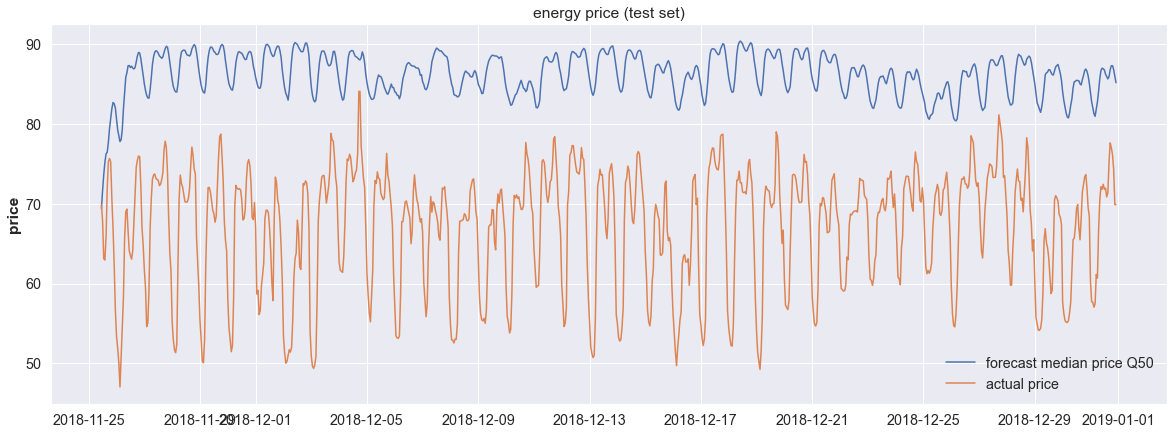

In [55]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
sns.set(font_scale=1.3)
p = sns.lineplot(x = "time", y = "Q50", data = dfY, palette="coolwarm")
sns.lineplot(x = "time", y = "Actual", data = dfY, palette="coolwarm")
plt.legend(labels=["forecast median price Q50", "actual price"])
p.set_ylabel("price")
p.set_xlabel("")
p.set_title("energy price (test set)");

# Out-of Sample Forecast

In [56]:
# choose forecast horizon: k hours beyond end of test set
k = 12   

n_FC = k + len(ts_ttest)   # length of test set + k hours
print("forecast beyond end of training set:", n_FC, 
      "hours beyond", ts_ttrain.end_time())

# last 24 hours of feature covariates available => copy them to future 24 hours:
covF_t_fut = covF_t.concatenate(    other=covF_t.tail(size=24), 
                                    ignore_time_axes=True)
# combine feature and time covariates:
cov_t_fut = covF_t_fut.concatenate(covT_t.slice_intersect(covF_t_fut), axis=1) 
cov_t_fut.pd_dataframe().iloc[[0,-1]]

forecast beyond end of training set: 888 hours beyond 2018-11-25 10:00:00+00:00


component,price_dayahead,gen_gas,gen_coal,temp_max_Seville,load_actual,temp_Seville,temp_min_Seville,temp_max_Madrid,temp_Madrid,temp_min_Barcelona,...,humidity_Madrid,wind_speed_Valencia,wind_speed_Madrid,gen_wind,gen_hyd_pump,hour,day_of_week,month,year,holidays
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,0.03,0.25,0.04,0.27,0.15,0.28,0.29,0.26,0.26,0.44,...,0.62,0.33,0.24,0.69,0.50,0.00,0.00,0.00,0.00,1.00
2019-01-01 22:00:00+00:00,0.76,0.52,0.24,0.30,0.26,0.29,0.27,0.15,0.16,0.17,...,0.72,0.13,0.06,0.22,0.03,0.96,0.17,0.00,1.00,1.00


In [57]:
# forecast from end of training set until k hours beyond end of test set
ts_tpred = model.predict(   n=n_FC, 
                            future_covariates=cov_t_fut, 
                            num_samples=N_SAMPLES, 
                            verbose=True, 
                            n_jobs=N_JOBS)
print("start:", ts_tpred.start_time(), "; end:",ts_tpred.end_time())


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# retrieve forecast series for chosen quantiles, 
# inverse-transform each series,
# insert them as columns in a new dataframe dfY
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
#dfY["Actual"] = TimeSeries.pd_series(ts_test)
 
# call helper function predQ, once for every quantile
_ = [predQ(ts_tpred, q) for q in QUANTILES]

# move Q50 column to the left, then insert Actual column
col = dfY.pop("Q50")
dfY.insert(0, col.name, col)
dfY.insert(0, "Actual", TimeSeries.pd_series(ts_test))

# show first and last 13 timestamps of forecast
dfY.iloc[np.r_[0:1, -13:0]]  

RMSE: 6.38
MAPE: 5.75


,Actual,Q50,Q01,Q10,Q20,Q80,Q90,Q99
time,,,,,,,,
2018-11-25 11:00:00+00:00,69.87,69.72,69.51,69.51,69.72,69.72,69.83,70.11
2018-12-31 22:00:00+00:00,69.88,67.99,67.74,67.89,67.92,68.07,68.13,68.42
2018-12-31 23:00:00+00:00,NaN,66.67,66.43,66.59,66.63,66.76,67.04,67.49
2019-01-01 00:00:00+00:00,NaN,58.84,58.51,58.70,58.79,58.95,58.99,59.28
2019-01-01 01:00:00+00:00,NaN,57.13,56.15,56.91,57.01,57.22,57.33,57.55
2019-01-01 02:00:00+00:00,NaN,56.28,55.84,56.02,56.15,56.40,56.61,56.73
2019-01-01 03:00:00+00:00,NaN,56.17,55.23,55.86,55.98,56.32,56.52,56.68
2019-01-01 04:00:00+00:00,NaN,56.34,55.92,56.07,56.24,56.51,56.75,57.02
2019-01-01 05:00:00+00:00,NaN,59.59,59.11,59.43,59.52,59.79,60.06,60.41


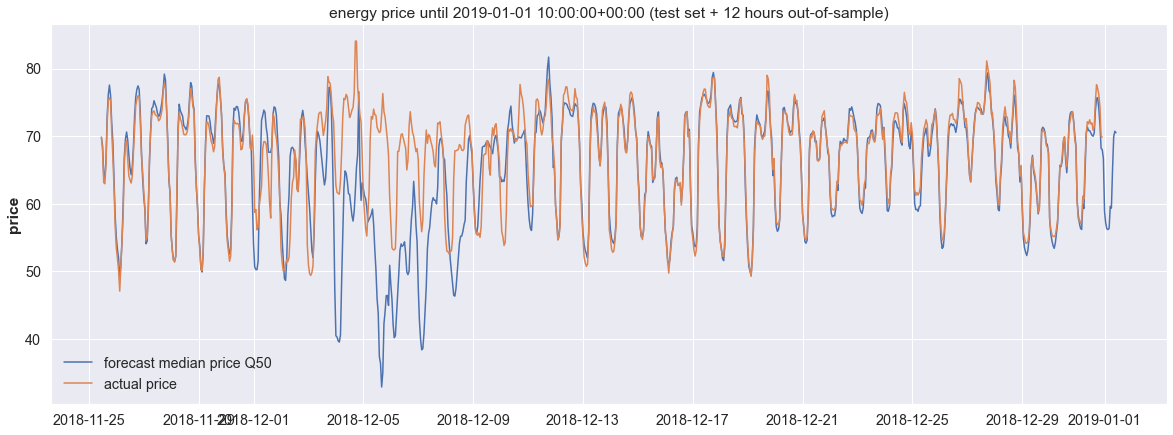

In [ ]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
sns.set(font_scale=1.3)
p = sns.lineplot(x = "time", y = "Q50", data = dfY, palette="coolwarm")
sns.lineplot(x = "time", y = "Actual", data = dfY, palette="coolwarm")
plt.legend(labels=["forecast median price Q50", "actual price"])
p.set_ylabel("price")
p.set_xlabel("")
end = ts_tpred.end_time()
p.set_title("energy price until {} (test set + {} hours out-of-sample)".format(end, k));